# Figures for Mn resuspension parameterization

- Appendix B: ArcticNet cast locations used for parameterization
- Appendix B: Observations and gaussian used for parameterization

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.basemap import Basemap, cm
import matplotlib
import netCDF4 as nc
import cmocean
import glob
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
from oceans import sw_extras as swe
from scipy.signal import savgol_filter
import pandas as pd
import warnings
import glob
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mesh_lon = mesh.variables['nav_lon']
mesh_lat = mesh.variables['nav_lat']
mesh_bathy = mesh.variables['hdept'][0]

In [4]:
mesh_lon = np.array(mesh_lon)
mesh_lat = np.array(mesh_lat)
mesh_bathy = np.array(mesh_bathy)

In [5]:
cond2 = (mesh_bathy > 0.1)
bathy_masked = np.ma.masked_where(cond2, mesh_bathy)

# ArcticNet transmissivity data from Polar Data Catalogue

In [6]:
folder_ArcticNet = '/ocean/brogalla/GEOTRACES/data/ArcticNet/'
sub2 = 'ArcticNet1003b_CTD_NorthWestPassage-v20140523/'
sub3 = 'ArcticNet0904a_CTD_CanadianArcticBaffinBay_v20140923/'
sub4 = 'ArcticNet1101_CTD_BaffinBay_NorthwestPassage_v20140922/'
sub5 = 'ArcticNet1001b_CTD_NorthWestPassage_v20140523/'
sub6 = 'ArcticNet1103b_ CTD_BaffinBay_NorthwestPassage_v20140922/'

List of filenames for each of these datasets

In [7]:
files2 = glob.glob(folder_ArcticNet+sub2+'*.int')
files3 = glob.glob(folder_ArcticNet+sub3+'*.int')
files4 = glob.glob(folder_ArcticNet+sub4+'*.int')
files5 = glob.glob(folder_ArcticNet+sub5+'*.int')
files6 = glob.glob(folder_ArcticNet+sub6+'*.int')

Function to read in data

In [8]:
def read_CTD(files, header_list):
    
    stn_lats=[]
    stn_lons=[]
    data_array=np.empty((len(files),1000,2)) # shape: (file, random length, [pressure, transmissivity])
    data_array[:] = np.nan
    i=0
    
    for file in files:
        stn = pd.read_fwf(file)
        stn = stn.iloc[0:10,1:2]
        lat = stn.iloc[5,:].str.extract('(\d+\.*\d*)', expand=False)
        lon = stn.iloc[6,:].str.extract('(\d+\.*\d*)', expand=False)
        stn_lats = np.append(stn_lats, float(lat))
        stn_lons = np.append(stn_lons, -1*float(lon))
        
        data  = pd.read_table(file, header=int(header_list[i]), sep='\s+')
        data  = data.drop(0) # drop empty row
        data  = data.dropna().astype(float)
        number_rows1 = len(data['Pres'])
        number_rows2 = len(data['Trans'])
        data_array[i,0:number_rows1,0] = np.array(data['Pres'])  # Pressure
        data_array[i,0:number_rows2,1] = np.array(data['Trans']) # Transmissivity
        i+=1
    
    return stn_lats, stn_lons, data_array

In [9]:
header_list2 = np.ones(len(files2))*12
header_list3 = np.ones(len(files3))*12
header_list4 = [13, 13, 12, 13, 13, 12, 13, 14, 12, 12, 14, 14, 14, 14, 12, 12, 12, 12, 14, 13, 14,\
                12, 14, 12, 13, 12, 13, 14, 14, 12, 12, 12, 12]
header_list5 = np.ones(len(files5))*12
header_list6 = [13, 13, 13, 14, 13, 14, 14, 13, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,\
                13, 14, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 13, 13, 13, 12, 13, 13, 13, 13, 13, 13, 13, 14]

In [10]:
stn_lats2, stn_lons2, data_array2 = read_CTD(files2, header_list2)
stn_lats3, stn_lons3, data_array3 = read_CTD(files3, header_list3)
stn_lats4, stn_lons4, data_array4 = read_CTD(files4, header_list4)
stn_lats5, stn_lons5, data_array5 = read_CTD(files5, header_list5)
stn_lats6, stn_lons6, data_array6 = read_CTD(files6, header_list6)

In [11]:
colors = ['#40e0d0', '#c71585', '#fdd835', '#9999ff', '#9be137', '#003366']

In [12]:
# bottom1 = (~np.isnan(data_array1[:,:,0])).sum(axis = 1) - 1 # should be identical for both P and T
bottom2 = (~np.isnan(data_array2[:,:,0])).sum(axis = 1) - 1 # should be identical for both P and T
bottom3 = (~np.isnan(data_array3[:,:,0])).sum(axis = 1) - 1 # should be identical for both P and T
bottom4 = (~np.isnan(data_array4[:,:,0])).sum(axis = 1) - 1 # should be identical for both P and T
bottom5 = (~np.isnan(data_array5[:,:,0])).sum(axis = 1) - 1 # should be identical for both P and T
bottom6 = (~np.isnan(data_array6[:,:,0])).sum(axis = 1) - 1 # should be identical for both P and T

## Metric for when transmissivity profiles indicate that resuspension is important

1. Compare cast depth with bottom depth at the same lat & lon
2. Smooth data
3. Calculate derivative of running average
4. Take the sum of the derivative values for the lowest 50 m and compare with average transmissivity derivative above that.

In [13]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.104, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # Added by BMM March 2017
        # If including points outside of domain:
        return np.nan, np.nan
        # raise ValueError(
        #    'No model point found. tol_lon/tol_lat too small or '
        #    'lon/lat outside of domain.')
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest

        # Avoiding array indexing because some functions
        # pass in model_lons and model_lats as netcdf4 objects
        # (which treat 'model_lons[j_list, i_list]' differently)
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


In [14]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [15]:
def find_bathy(stn, bottom, stn_lons, stn_lats, mesh_lon=mesh_lon, mesh_lat=mesh_lat):
    
    cast_depth = bottom[stn]
    lon = stn_lons[stn]
    lat = stn_lats[stn]
    
    # Find bathymetry
    i, j        = find_closest_model_point(lon, lat, mesh_lon, mesh_lat)
    bathy_depth = mesh_bathy[i,j]
    
    return bathy_depth, cast_depth

In [16]:
cruise2_bathy=[]
cruise2_cast =[]

for i in range(0,len(bottom2)):
    bathy, cast   = find_bathy(i, bottom2, stn_lons2, stn_lats2)
    cruise2_bathy = np.append(cruise2_bathy, bathy)
    cruise2_cast  = np.append(cruise2_cast, cast)

In [17]:
cruise3_bathy=[]
cruise3_cast =[]

for i in range(0,len(bottom3)):
    bathy, cast   = find_bathy(i, bottom3, stn_lons3, stn_lats3)
    cruise3_bathy = np.append(cruise3_bathy, bathy)
    cruise3_cast  = np.append(cruise3_cast, cast)

In [18]:
cruise4_bathy=[]
cruise4_cast =[]

for i in range(0,len(bottom4)):
    bathy, cast   = find_bathy(i, bottom4, stn_lons4, stn_lats4)
    cruise4_bathy = np.append(cruise4_bathy, bathy)
    cruise4_cast  = np.append(cruise4_cast, cast)

In [19]:
cruise5_bathy=[]
cruise5_cast =[]

for i in range(0,len(bottom5)):
    bathy, cast   = find_bathy(i, bottom5, stn_lons5, stn_lats5)
    cruise5_bathy = np.append(cruise5_bathy, bathy)
    cruise5_cast  = np.append(cruise5_cast, cast)

In [20]:
cruise6_bathy=[]
cruise6_cast =[]

for i in range(0,len(bottom6)):
    bathy, cast   = find_bathy(i, bottom6, stn_lons6, stn_lats6)
    cruise6_bathy = np.append(cruise6_bathy, bathy)
    cruise6_cast  = np.append(cruise6_cast, cast)

Depth above bottom for the end of each cast:

In [21]:
depth_diff2 = np.abs(cruise2_bathy - cruise2_cast)
depth_diff3 = np.abs(cruise3_bathy - cruise3_cast)
depth_diff4 = np.abs(cruise4_bathy - cruise4_cast)
depth_diff5 = np.abs(cruise5_bathy - cruise5_cast)
depth_diff6 = np.abs(cruise6_bathy - cruise6_cast)

1. Stations with casts within about 30 m of the ocean floor:

In [22]:
# c = ['#feda84', '#ff9b83', colors[1], '#976393', colors[3], '#43457f']

In [38]:
c = ['#dbf397', '#9bb976', '#adccef', '#3381d8', '#19406c']

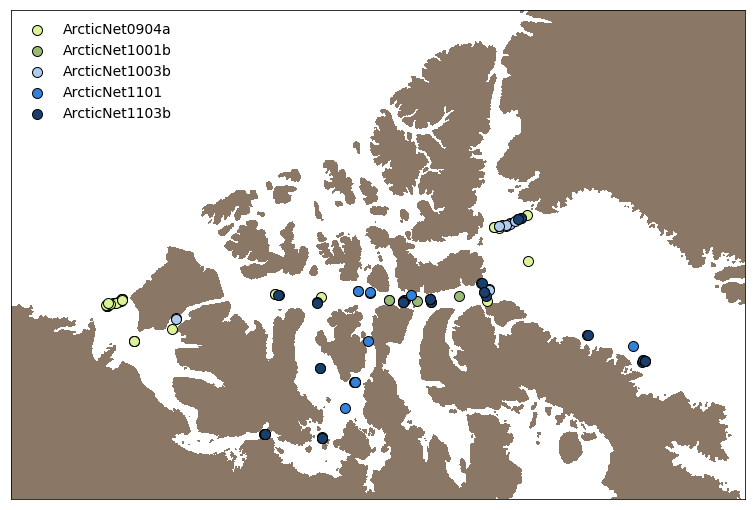

In [39]:
fig,ax = plt.subplots(figsize=(14,9))

proj=Basemap(projection='eqdc',lat_0 = 76, lon_0 = -95, resolution='i', width=3.00e6, height=2.0e6)
x_mesh, y_mesh = proj(mesh_lon, mesh_lat)
proj.contourf(x_mesh, y_mesh, bathy_masked, vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

x2, y2 = proj(stn_lons2, stn_lats2)
x3, y3 = proj(stn_lons3, stn_lats3)
x4, y4 = proj(stn_lons4, stn_lats4)
x5, y5 = proj(stn_lons5, stn_lats5)
x6, y6 = proj(stn_lons6, stn_lats6)
proj.scatter(x3[depth_diff3 < 30], y3[depth_diff3 < 30], marker='.', s=400, edgecolor='k', \
             color=c[0], zorder=3, label='ArcticNet0904a')
proj.scatter(x5[depth_diff5 < 30], y5[depth_diff5 < 30], marker='.', s=400, edgecolor='k', \
             color=c[1], zorder=3, label='ArcticNet1001b')
proj.scatter(x2[depth_diff2 < 30], y2[depth_diff2 < 30], marker='.', s=400, edgecolor='k', \
             color=c[2], zorder=3, label='ArcticNet1003b')
proj.scatter(x4[depth_diff4 < 30], y4[depth_diff4 < 30], marker='.', s=400, edgecolor='k', \
             color=c[3], zorder=3, label='ArcticNet1101')
proj.scatter(x6[depth_diff6 < 30], y6[depth_diff6 < 30], marker='.', s=400, edgecolor='k', \
             color=c[4], zorder=3, label='ArcticNet1103b')

ax.legend(fontsize=14, frameon=False, loc=2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/figB1-resuspension.png', bbox_inches='tight', dpi=300)

2. Bottom depth vs. Transmissivity:

In [24]:
def bottom_trans(ax, data_array, depth_diff, bottom, cruise_bathy, color):
    data_x1 = data_array[depth_diff < 30, :, 1] # transmissivity
    data_y1 = data_array[depth_diff < 30, :, 0] # depth of measurement (pressure) (cast, depths)
    
    # depth of bathymetry
    data_y2 = cruise_bathy[depth_diff < 30]
    
    # bottom depth of cast
    bot1 = bottom[depth_diff < 30]
    
    # loop through each cast
    for i in range(0, len(bot1)):
        ind1 = np.argmin(np.abs(data_y1[i,:]-bot1[i])) # find closest point to bottom bathymetry
        ind2 = ind1-5
        
        # calculate transmissivity drop by taking average of bottom 5m - average of upper 80m
        transmissivity = np.average(data_x1[i, ind2:ind1]) - np.average(data_x1[i, ind2-80:ind2])
        depth          = data_y2[i] 
        
        ax.plot(transmissivity, depth, '.', c=color, markersize=18, markeredgecolor='k')
        
    return

In [25]:
m      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc')
mdepth = np.array(m.variables['deptht'])

In [26]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

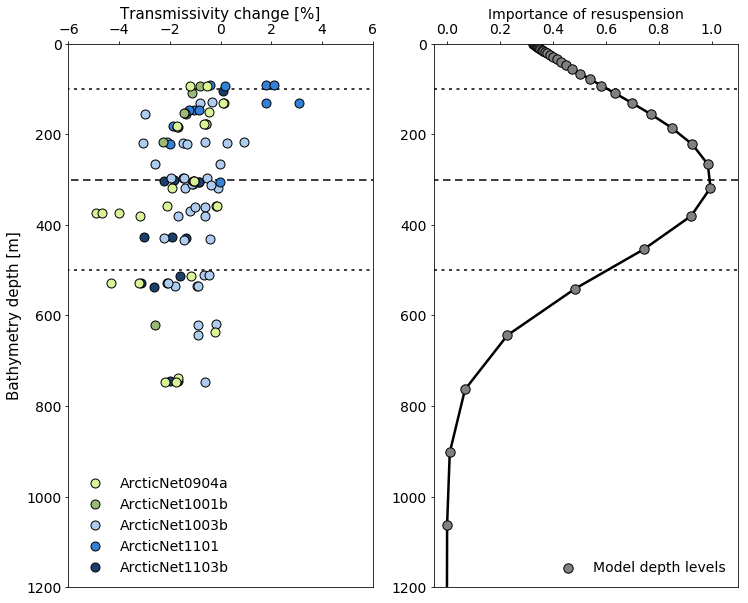

In [37]:
fig, ax = plt.subplots(1,2,figsize=(12,10))

ax[0].invert_yaxis()


bottom_trans(ax[0], data_array2, depth_diff2, bottom2, cruise2_bathy, c[4])
bottom_trans(ax[0], data_array3, depth_diff3, bottom3, cruise3_bathy, c[2])
bottom_trans(ax[0], data_array4, depth_diff4, bottom4, cruise4_bathy, c[3])
bottom_trans(ax[0], data_array5, depth_diff5, bottom5, cruise5_bathy, c[1])
bottom_trans(ax[0], data_array6, depth_diff6, bottom6, cruise6_bathy, c[0])

# entries for legend:
ax[0].plot(-20,0, '.', c=c[0], markersize=18, markeredgecolor='k', label='ArcticNet0904a')
ax[0].plot(-20,0, '.', c=c[1], markersize=18, markeredgecolor='k', label='ArcticNet1001b')
ax[0].plot(-20,0, '.', c=c[2], markersize=18, markeredgecolor='k', label='ArcticNet1003b')
ax[0].plot(-20,0, '.', c=c[3], markersize=18, markeredgecolor='k', label='ArcticNet1101')
ax[0].plot(-20,0, '.', c=c[4], markersize=18, markeredgecolor='k', label='ArcticNet1103b')
ax[0].legend(fontsize=14, frameon=False)

# horizontal lines:
ax[0].plot([-10, 10], [100, 100], '--k', dashes=(2, 3), zorder=1)
ax[0].plot([-10, 10], [300, 300], '--k', dashes=(5, 3), zorder=1)
ax[0].plot([-10, 10], [500, 500], '--k', dashes=(2, 3), zorder=1)

ax[0].xaxis.set_tick_params(labelsize=14)
ax[0].yaxis.set_tick_params(labelsize=14)
ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.tick_top()
ax[0].set_ylabel('Bathymetry depth [m]', fontsize=15)
ax[0].set_xlabel('Transmissivity change [%]', fontsize=15)
ax[0].set_ylim([1200, 0]);
ax[0].set_xlim([-6, 6]);


#-------- Plot 2 --------------------------------------------
ax[1].invert_yaxis()
ax[1].plot(gaussian(mdepth, 300, 200), mdepth, c='k', linewidth=2.5)
ax[1].scatter(gaussian(mdepth, 300, 200), mdepth, marker='.', color='gray', edgecolor='k', s=350, zorder=3,\
             label='Model depth levels')
ax[1].legend(fontsize=14, frameon=False)

# Reference lines
ax[1].plot([-10, 10], [100, 100], '--k', dashes=(2, 3), zorder=1)
ax[1].plot([-10, 10], [300, 300], '--k', dashes=(5, 3), zorder=1)
ax[1].plot([-10, 10], [500, 500], '--k', dashes=(2, 3), zorder=1)

# Settings:
ax[1].xaxis.tick_top()
ax[1].xaxis.set_tick_params(labelsize=14)
ax[1].yaxis.set_tick_params(labelsize=14)
ax[1].xaxis.set_label_position('top') 
ax[1].set_xlim([-0.05, 1.1])
ax[1].set_ylim([1200, 0])
ax[1].set_xlabel('Importance of resuspension', fontsize=14)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/figB2-resuspension.png', bbox_inches='tight', dpi=300)